# 2D Laplace Equation
We want to solve:
$$
\nabla^2 u = \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = 0
$$

Using finite differences:

$$
u_{i,j} = \frac{1}{4}
\left(
u_{i+1,j} +
u_{i-1,j} +
u_{i,j+1} +
u_{i,j-1}
\right)
$$

This gives an easy iterative method:

1. Initialize a grid.
2. Apply boundary conditions.
3. Repeatedly update each interior point using the formula.
4. Stop when the solution converges.



## Jacobi Iterative Solver

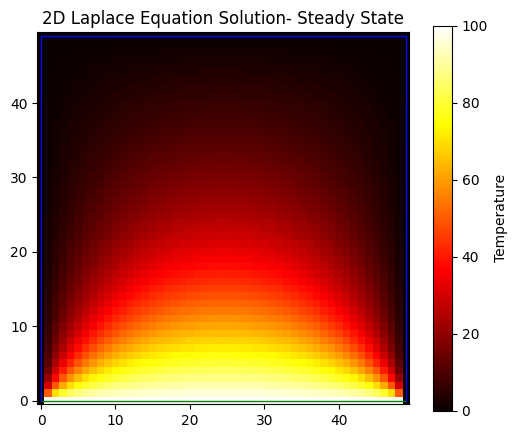

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Grid size
nx, ny = 50, 50
max_iter = 5000

# Initialize grid
u = np.zeros((ny, nx))

# Boundary conditions
u[0, :] = 100.0     # Top boundary = 100
u[-1, :] = 0.0       # Bottom = 0
u[:, 0] = 0.0        # Left = 0
u[:, -1] = 0.0       # Right = 0
epsilon = 1e-5


# Iterative solution (Jacobi method)
for it in range(max_iter):
    u_old = u.copy()
    
    # Update interior points
    # ui,j​(1/4)​[(u_i+1,j​) + (u_i−1,j​)+(ui,j+1​)+(ui,j−1​)]
    u[1:-1, 1:-1] = (1/4) * (
        u_old[1:-1, 2:] +
        u_old[1:-1, 0:-2] +
        u_old[2:, 1:-1] +
        u_old[0:-2, 1:-1]
    )

    # Check convergence (optional)
    if np.linalg.norm(u - u_old) < epsilon:
        print(f"Converged at iteration {it}")
        break

# Plot the result
plt.figure(figsize=(6,5))
plt.imshow(u, cmap='hot', origin='lower')
plt.colorbar(label='Temperature')
plt.title("2D Laplace Equation Solution- Steady State")

# Grid size
ny, nx = u.shape

# Highlight boundaries with blue lines
# Top boundary
plt.plot([0, nx-1], [0, 0], color='green', linewidth=1)
# Bottom boundary
plt.plot([0, nx-1], [ny-1, ny-1], color='blue', linewidth=1)
# Left boundary
plt.plot([0, 0], [0, ny-1], color='blue', linewidth=1)
# Right boundary
plt.plot([nx-1, nx-1], [0, ny-1], color='blue', linewidth=1)

plt.show()


## Stability/Convergence Check

Converged at iteration 4389


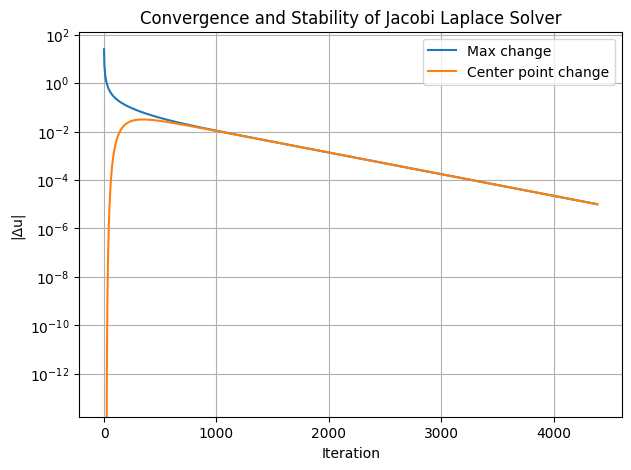

In [32]:
import numpy as np
import matplotlib.pyplot as plt

nx, ny = 50, 50
max_iter = 5000
epsilon = 1e-5

u = np.zeros((ny, nx))
u[0, :] = 100.0
u[-1, :] = 0.0
u[:, 0] = 0.0
u[:, -1] = 0.0

max_changes = []
center_changes = []

for it in range(max_iter):
    u_old = u.copy()
    u[1:-1, 1:-1] = 0.25 * (
        u_old[1:-1, 2:] + u_old[1:-1, 0:-2] +
        u_old[2:, 1:-1] + u_old[0:-2, 1:-1]
    )
    delta = np.abs(u - u_old)
    max_changes.append(np.max(delta))
    center_changes.append(delta[ny//2, nx//2])
    if np.max(delta) < epsilon:
        print(f"Converged at iteration {it}")
        break

plt.figure(figsize=(7,5))
plt.semilogy(max_changes, label='Max change')
plt.semilogy(center_changes, label='Center point change')
plt.xlabel("Iteration")
plt.ylabel("|Δu|")
plt.title("Convergence and Stability of Jacobi Laplace Solver")
plt.grid(True)
plt.legend()
plt.show()


## Use of Laplace Equation for Image inpainting/Restoration

Converged at iteration 749


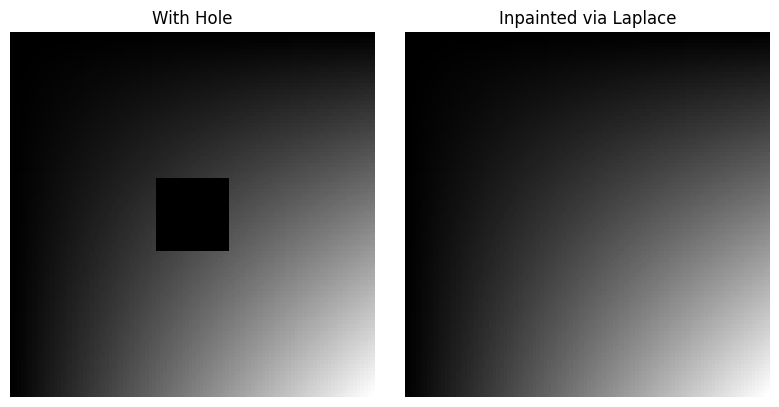

In [86]:
import numpy as np
import matplotlib.pyplot as plt

# Create a simple smooth image (gradient)
ny, nx = 100, 100
y = np.linspace(0, 1, ny)
x = np.linspace(0, 1, nx)
img = np.outer(y, x)  # simple smooth gradient

# Introduce a hole: a small rectangle in the middle
mask = np.zeros_like(img, dtype=bool)
mask[40:60, 40:60] = True
img_with_hole = img.copy()
img_with_hole[mask] = 0.0  # initial guess inside the hole

# Laplace inpainting (Jacobi method)
u = img_with_hole.copy()
max_iter = 2000
epsilon = 1e-6

for it in range(max_iter):
    u_old = u.copy()
    # update only masked pixels
    for j in range(1, ny-1):
        for i in range(1, nx-1):
            if mask[j,i]:
                u[j,i] = 0.25 * (u_old[j+1,i] + u_old[j-1,i] + u_old[j,i+1] + u_old[j,i-1])
    if np.max(np.abs(u - u_old)) < epsilon:
        print(f"Converged at iteration {it}")
        break

# Plot results
plt.figure(figsize=(12,4))
plt.subplot(1,3,2)
plt.imshow(img_with_hole, cmap='gray')
plt.title("With Hole")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(u, cmap='gray')
plt.title("Inpainted via Laplace")
plt.axis('off')

plt.tight_layout()
plt.show()

# Save original image with hole
plt.imsave('../assets/original_with_hole.png', img_with_hole, cmap='gray')

# Save inpainted image
plt.imsave('../assets/inpainted.png', u, cmap='gray')


## Image Restoration

/tmp/ipykernel_34723/3107777096.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(img_path).astype(np.float64) / 255.0


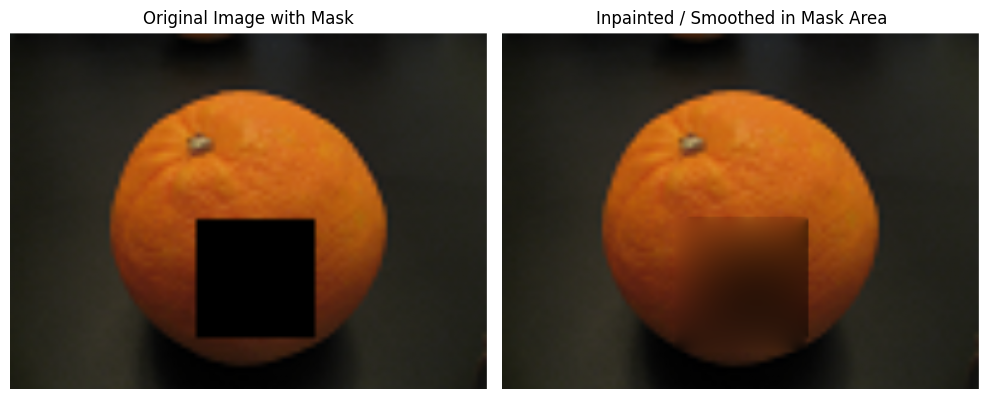

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread

# Load the image
img_path = "../assets/orange-with-black-rectangle.png"
img = imread(img_path).astype(np.float64) / 255.0

ny, nx = img.shape[:2]

# Mask coordinates (known black rectangle)
mask_height = 110
mask_width = 110

y_start = 155
y_end = y_start + mask_height

x_start = nx//2 - mask_width//2
x_end = x_start + mask_width

mask = np.zeros((ny, nx), dtype=bool)
mask[y_start:y_end, x_start:x_end] = True

# Damaged image: initialize u with **original values from the mask**
u = img.copy()
# No need to overwrite the mask area; it already has the original image pixels
# u[mask] = img[mask]  # optional, redundant here

# Jacobi iterative Laplace inpainting (if you still want smoothing in the mask)
max_iter = 3000
epsilon = 1e-8
channels = img.shape[2]

for it in range(max_iter):
    u_old = u.copy()
    for j in range(1, ny-1):
        for i in range(1, nx-1):
            if mask[j,i]:
                for c in range(channels):
                    u[j,i,c] = 0.25 * (
                        u_old[j+1,i,c] + u_old[j-1,i,c] +
                        u_old[j,i+1,c] + u_old[j,i-1,c]
                    )
    if np.max(np.abs(u - u_old)) < epsilon:
        print(f"Converged at iteration {it}")
        break

# Plot results
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original Image with Mask")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(u)
plt.title("Inpainted / Smoothed in Mask Area")
plt.axis('off')

plt.tight_layout()
plt.show()
